In [1]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.utils import shuffle
import pandas as pd

In [2]:
class_names = ['NORMAL', 'PNEUMONIA']
class_names_label = {}
for i in range(len(class_names)):
    class_names_label[class_names[i]] = i

img_size = (150, 150)

class_names_label

{'NORMAL': 0, 'PNEUMONIA': 1}

In [3]:
def lungs_segmented(img):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    ret1, th1 = cv.threshold(gray, 156, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    kernel = np.ones([3,3], np.uint8)
    th1_m = cv.morphologyEx(th1, cv.MORPH_OPEN, kernel, 2)
    th1_m_d = cv.dilate(th1_m, kernel, 3)
    th1_m_d_dt = cv.distanceTransform(th1_m_d, cv.DIST_L2, 5)
    retth1, th1_m_d_dt_th = cv.threshold(th1_m_d_dt, 0.7*th1_m_d_dt.max(), 255, cv.THRESH_BINARY)
    th1_m_d_dt_th = np.uint8(th1_m_d_dt_th)
    unknown = cv.subtract(th1_m_d,th1_m_d_dt_th)
    ret, markers = cv.connectedComponents(th1_m_d_dt_th)
    markers = markers + 1
    markers[unknown==255] = 0
    markers = cv.watershed(img, markers)
    img[markers == -1] = [255, 255,0]
    
    return img

def load_data():
    
    folders = ['../pneumonia_detection/chest_xray/train', '../pneumonia_detection/chest_xray/test']
    df = []
    
    for folder in folders:
        images = []
#         images_segmented = []
        labels = []
        
        print(f'Loading {format(folder)}')
        
        for class_name in os.listdir(folder):
            label = class_names_label[class_name]
            
            for file in tqdm(os.listdir(os.path.join(folder, class_name))):
                img_path = os.path.join(os.path.join(folder, class_name), file)
                
                img = cv.imread(img_path)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = cv.resize(img, img_size)
                
                images.append(img)
#                 images_segmented.append(lungs_segmented(img))
                labels.append(label)

        images = np.array(images, dtype='float32')
#         images_segmented = np.array(images_segmented, dtype='float32')
        labels = np.array(labels, dtype='int32')

#         df.append((images, images_segmented, labels))
        df.append((images, labels))
        
    return df

In [4]:
# (train_images, train_images_segmented, train_labels), (test_images, test_images_segmented, test_labels) = load_data()
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ../pneumonia_detection/chest_xray/train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3875/3875 [01:32<00:00, 41.78it/s]


Loading ../pneumonia_detection/chest_xray/test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 63.08it/s]


In [5]:
train_images.shape, test_images.shape

((5216, 150, 150, 3), (624, 150, 150, 3))

In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

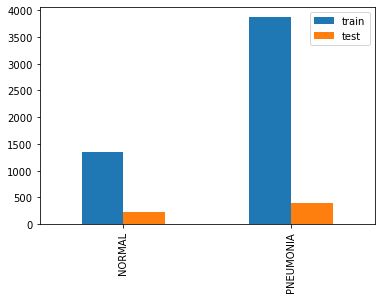

In [7]:
train_counts = np.unique(train_labels, return_counts=True)[1]
test_counts = np.unique(test_labels, return_counts=True)[1]
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar()
plt.show()

In [8]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

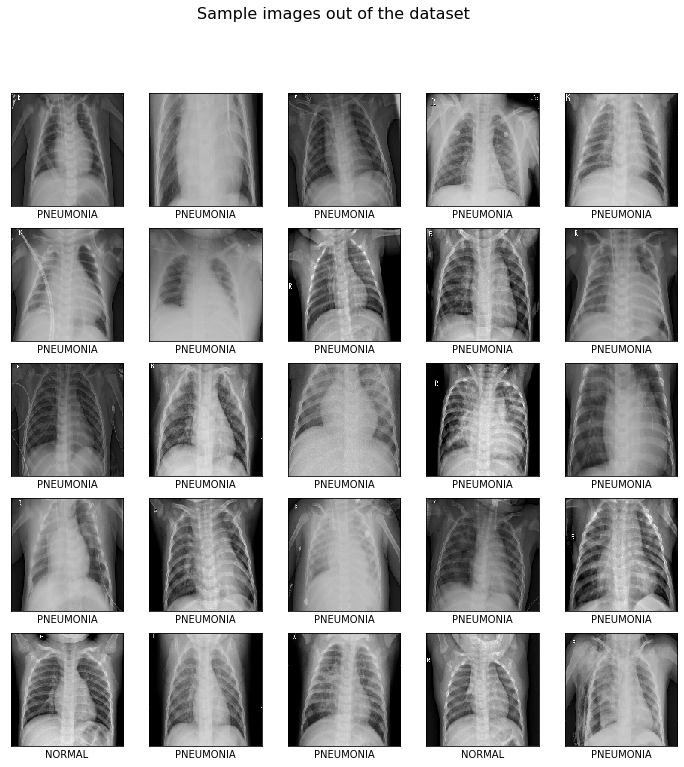

In [9]:
fig = plt.figure(figsize=(12,12))
fig.suptitle("Sample images out of the dataset", fontsize=16)

for i in range(25):
    temp = np.random.randint(0, train_images.shape[0])
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[temp], cmap="binary")
    plt.xlabel(class_names[train_labels[temp]])
plt.show()

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
train_images.shape, test_images.shape

((5216, 150, 150, 3), (624, 150, 150, 3))

In [13]:
history = model.fit(train_images, train_labels, batch_size=256, epochs=10, validation_split = 0.3)

Epoch 1/10
15/15 [==============================] - 74s 4s/step - loss: 1.4857 - accuracy: 0.6123 - val_loss: 0.4787 - val_accuracy: 0.7987
Epoch 2/10
15/15 [==============================] - 59s 3s/step - loss: 0.3800 - accuracy: 0.8449 - val_loss: 0.2774 - val_accuracy: 0.8927
Epoch 3/10
15/15 [==============================] - 37s 3s/step - loss: 0.2059 - accuracy: 0.9153 - val_loss: 0.1394 - val_accuracy: 0.9470
Epoch 4/10
15/15 [==============================] - 37s 3s/step - loss: 0.1159 - accuracy: 0.9597 - val_loss: 0.1067 - val_accuracy: 0.9604
Epoch 5/10
15/15 [==============================] - 39s 3s/step - loss: 0.0852 - accuracy: 0.9705 - val_loss: 0.1104 - val_accuracy: 0.9604
Epoch 6/10
15/15 [==============================] - 39s 3s/step - loss: 0.0673 - accuracy: 0.9769 - val_loss: 0.0912 - val_accuracy: 0.9706
Epoch 7/10
15/15 [==============================] - 39s 3s/step - loss: 0.0583 - accuracy: 0.9788 - val_loss: 0.0984 - val_accuracy: 0.9649
Epoch 8/10
15/15 [==

In [14]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

20/20 - 2s - loss: 1.2545 - accuracy: 0.7388

Test accuracy: 0.7387820482254028


In [32]:
def plot_history(history):
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([min(history.history['loss'] + history.history['val_loss']),
              max(history.history['accuracy'] + history.history['val_accuracy'])])
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)

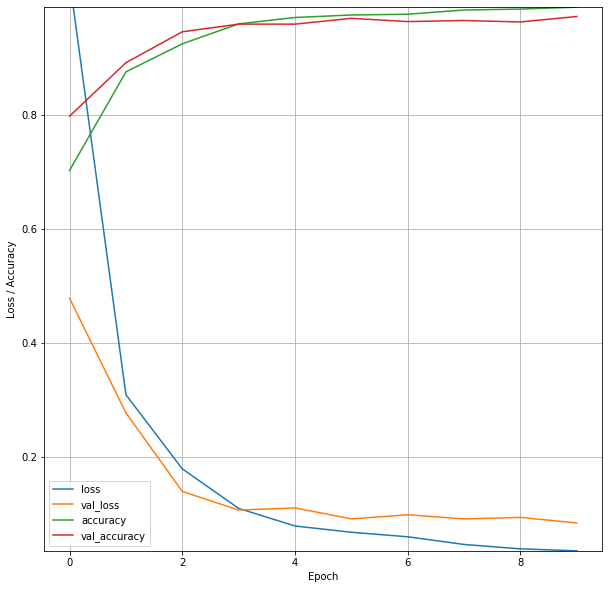

In [33]:
plot_history(history)

In [18]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [19]:
predictions = probability_model.predict(test_images)

In [20]:
predictions[0]

array([0.54504097, 0.45495906], dtype=float32)

In [21]:
np.argmax(predictions[0])

0

In [22]:
test_labels[0]

0

In [23]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap='binary')

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{}\n{}".format('P: ' + class_names[predicted_label],
                                'T: ' + class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label, classes):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(len(classes)))
    plt.yticks([])
    thisplot = plt.bar(range(len(classes)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

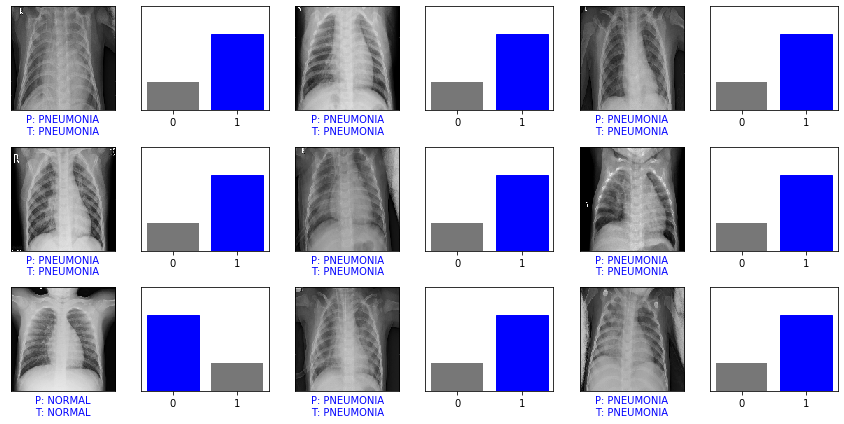

In [24]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
temp_list = []
for i in range(num_images):
    temp = np.random.randint(0, test_images.shape[0]-1)
    if temp not in temp_list:
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(temp, predictions[temp], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(temp, predictions[temp], test_labels, class_names_label)
        temp_list.append(temp)
    else:
        i -= 1
plt.tight_layout()
plt.show()

In [25]:
print(f'predictions: {len(predictions)}\ntest labels: {len(test_labels)}')

predictions: 624
test labels: 624


In [26]:
true_pneumonia_count = 0
true_normal_count = 0
false_pneumonia_count = 0
false_normal_count = 0
for i in range(len(predictions)):
    if np.argmax(predictions[i]) == test_labels[i]:
        if test_labels[i] == 0:
            true_normal_count += 1
        elif test_labels[i] == 1:
            true_pneumonia_count += 1
    else:
        if test_labels[i] == 0:
            false_pneumonia_count += 1
        elif test_labels[i] == 1:
            false_normal_count += 1

In [27]:
print(f'true normal: {true_normal_count}\nfalse normal: {false_normal_count}\ntrue pneumonia: {true_pneumonia_count}\nfalse pneumonia: {false_pneumonia_count}')

true normal: 72
false normal: 1
true pneumonia: 389
false pneumonia: 162


In [59]:
false_pneumonia_index_list = []

for i in range(len(predictions)):
    if np.argmax(predictions[i]) != test_labels[i]:
        if np.argmax(predictions[i]) == 1 and test_labels[i] == 0:
            false_pneumonia_index_list.append(i)

print(len(false_pneumonia_index_list))

162


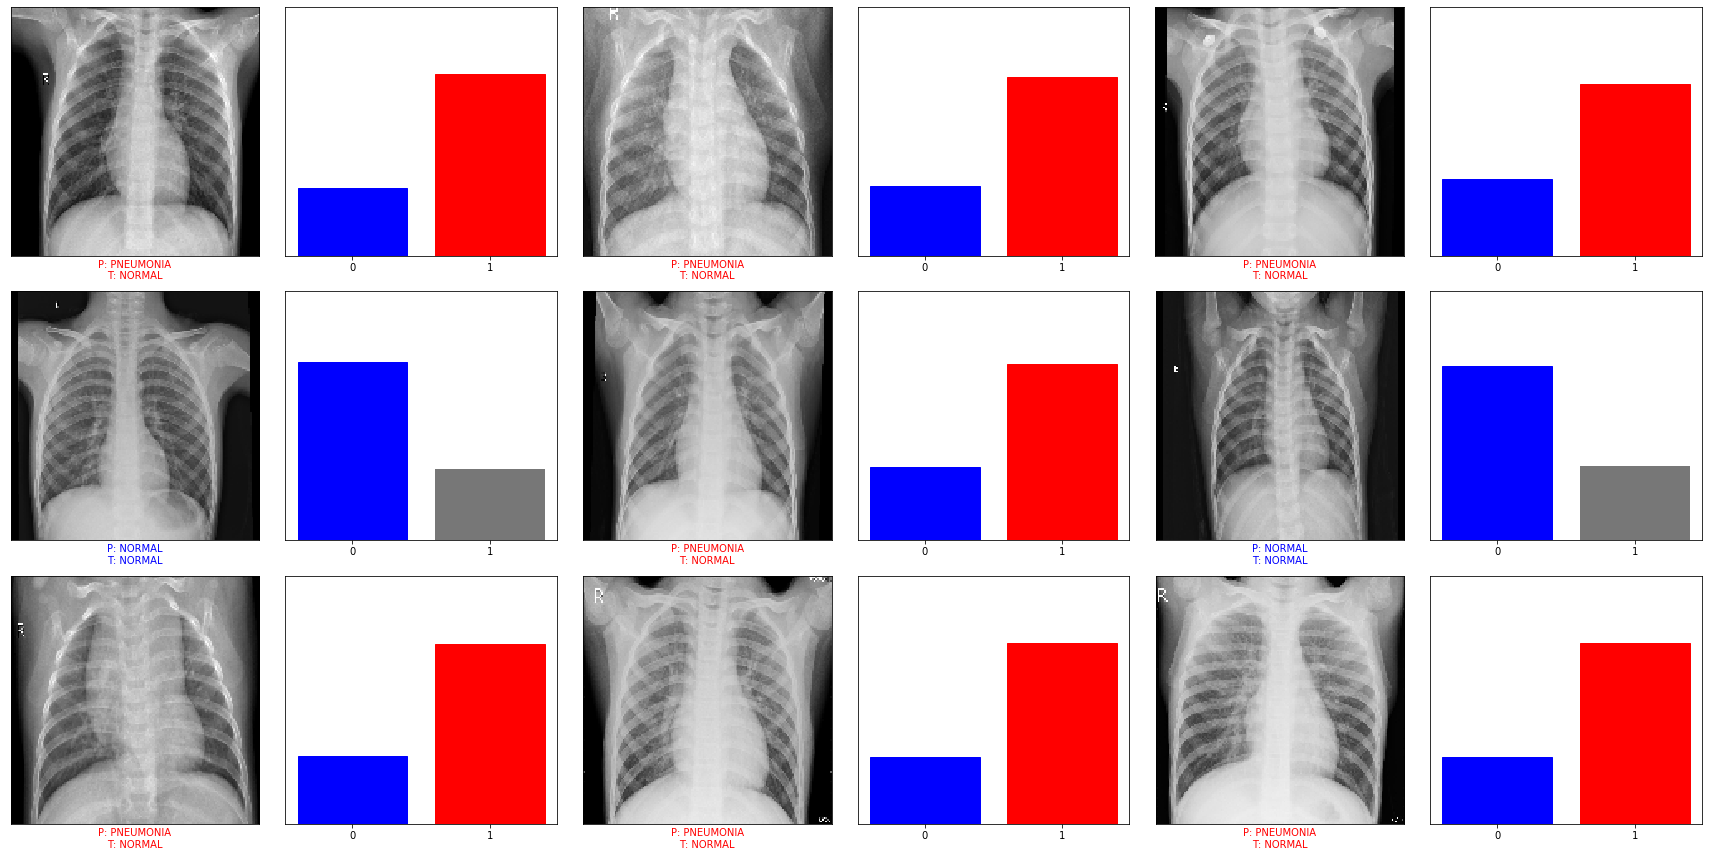

In [64]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(8*num_cols, 4*num_rows))
temp_list_new = []
for i in range(num_images):
    temp = np.random.randint(0, len(false_pneumonia_index_list))
    if temp not in temp_list_new:
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(temp, predictions[temp], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(temp, predictions[temp], test_labels, class_names_label)
        temp_list_new.append(temp)
    else:
        i -= 1
plt.tight_layout()
plt.show()

Looking at the some of images from above with incorrect predictions, I could assume that maybe dataset has an errors in it, or maybe some od images from dataset has no pneumonia, but other health issues.

# Final

I've got accuracy of 73% in my predictions. The biggest problem is that I have almost all of my incorrect predictions are False Pneumonia, which means that greates part of normal lungs are predicted as unhealthy lungs (69%).

Currently, I do not know how this model could be improved.